In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [28]:
df = pd.read_csv('weather_data.csv')

In [29]:
df = pd.DataFrame(df)

In [30]:
df.head(5)

,time,temp,wind_speed,wind_degree,pressure,precip,humidity,cloud,uv,weather
0,2024-11-01 00:00,26.2,4.7,180,29.82,0.0,76,80,0.0,1063
1,2024-11-01 01:00,26.0,5.4,192,29.81,0.0,75,76,0.0,1063
2,2024-11-01 02:00,26.0,5.0,207,29.79,0.0,75,17,0.0,1000
3,2024-11-01 03:00,25.8,6.1,212,29.79,0.0,75,16,0.0,1000
4,2024-11-01 04:00,25.7,5.8,207,29.81,0.0,75,14,0.0,1000


In [31]:
df.duplicated().sum()

0

In [32]:
training = df.drop(['time', 'weather', 'precip', 'uv'], axis=1)

In [33]:
training.head(5)

,temp,wind_speed,wind_degree,pressure,humidity,cloud
0,26.2,4.7,180,29.82,76,80
1,26.0,5.4,192,29.81,75,76
2,26.0,5.0,207,29.79,75,17
3,25.8,6.1,212,29.79,75,16
4,25.7,5.8,207,29.81,75,14


In [34]:
len(training)

744

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(training)

In [36]:
import pickle

# Save the scaler as a .pkl file
scaler_path = 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)

print(f"Scaler saved as {scaler_path}")

Scaler saved as scaler.pkl


In [37]:
pd.DataFrame(train_scaled).head(5)

,0,1,2,3,4,5
0,0.304348,0.217172,0.501393,0.653846,0.612245,0.791667
1,0.286957,0.252525,0.534819,0.615385,0.591837,0.750000
2,0.286957,0.232323,0.576602,0.538462,0.591837,0.135417
3,0.269565,0.287879,0.590529,0.538462,0.591837,0.125000
4,0.260870,0.272727,0.576602,0.615385,0.591837,0.104167


In [38]:
def create_sequences(data, sequence_length, forecast_horizon):
    X, y = [], []
    for i in range(len(data) - sequence_length - forecast_horizon):
        X.append(data[i:i + sequence_length, :])
        y.append(data[i + sequence_length:i + sequence_length + forecast_horizon, :])
        
    return np.array(X), np.array(y)

In [39]:
sequence_length = 6
forecast_horizon = 1

X, y = create_sequences(train_scaled, sequence_length, forecast_horizon)

In [40]:
split_ratio = 0.8
split = int(split_ratio * len(X))

x_train, x_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [41]:
num_features = X.shape[2]

model = tf.keras.Sequential([    
    tf.keras.layers.Input(shape=(sequence_length, num_features)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(256, return_sequences=True)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(192, return_sequences=False)),
    tf.keras.layers.BatchNormalization(),
    # tf.keras.layers.Bidirectional(tf.keras.layers.GRU(128, return_sequences=False)),
    # tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(192, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
    tf.keras.layers.Dense(num_features * forecast_horizon),  
    tf.keras.layers.Reshape((forecast_horizon, num_features))
])

model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9), loss='mae', metrics=['mean_absolute_error'])

In [42]:
init_weights = model.get_weights()

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 6, 512)         │       405,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 6, 512)         │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 384)            │       813,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 384)            │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        49,280 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 192)            │        24,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 6)              │         1,542 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 1, 6)           │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,347,398 (5.14 MB)

 Trainable params: 1,345,606 (5.13 MB)

 Non-trainable params: 1,792 (7.00 KB)

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

reduce_lr = ReduceLROnPlateau(monitor='val_mean_absolute_error', factor = 0.5, patience=4, min_lr=1e-6)

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomEarlyStopping(Callback):
    def on_epoch_end(self, epoch, logs):
        if logs['mean_absolute_error'] <= 0.058 and logs['val_mean_absolute_error'] <= 0.060:
            self.model.stop_training = True

custom_early_stopping = CustomEarlyStopping()

In [49]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Reset the weights
model.set_weights(init_weights)

In [50]:
history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[custom_early_stopping])
# history = model.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=100, batch_size=16, verbose=1, callbacks=[reduce_lr])

Epoch 1/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 5.8153 - mean_absolute_error: 0.3805 - val_loss: 5.1561 - val_mean_absolute_error: 0.3121
Epoch 2/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.7855 - mean_absolute_error: 0.1193 - val_loss: 4.4242 - val_mean_absolute_error: 0.2626
Epoch 3/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 4.1079 - mean_absolute_error: 0.0984 - val_loss: 3.8197 - val_mean_absolute_error: 0.2426
Epoch 4/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 3.5341 - mean_absolute_error: 0.0871 - val_loss: 3.2962 - val_mean_absolute_error: 0.2199
Epoch 5/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 3.0582 - mean_absolute_error: 0.0934 - val_loss: 2.8432 - val_mean_absolute_error: 0.1962
Epoch 6/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.6296 - mean_absolute_error: 0.0785 - val_loss: 2.4626 - val_mean_absolute_error: 0.1843
Epoch 7/100
37/37 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 2.2753 - mean_absolute_error: 0.0795 - v

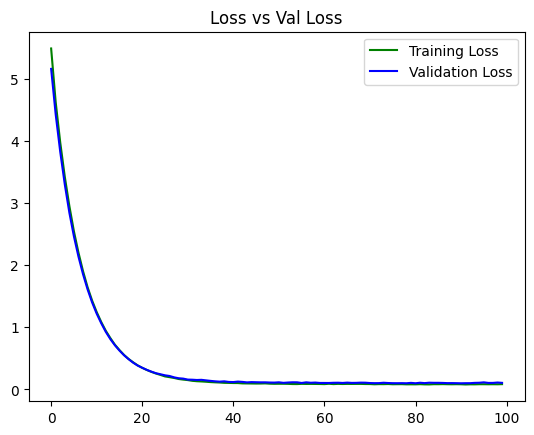

In [51]:
plt.plot(history.history['loss'], color='g', label='Training Loss')
plt.plot(history.history['val_loss'], color='b', label='Validation Loss')
plt.title("Loss vs Val Loss")
plt.legend()
plt.show()

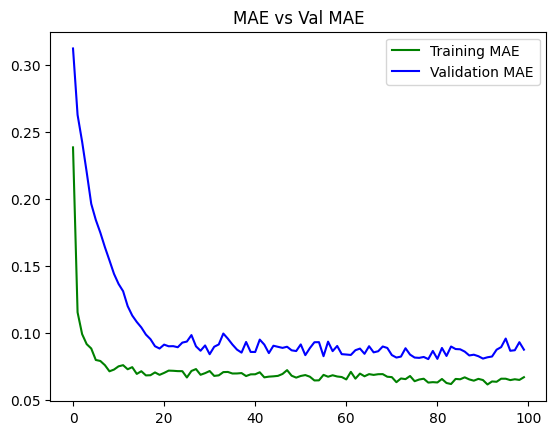

In [55]:
plt.plot(history.history['mean_absolute_error'], color='g', label='Training MAE')
plt.plot(history.history['val_mean_absolute_error'], color='b', label='Validation MAE')
plt.title("MAE vs Val MAE")
plt.legend()
plt.show()

In [56]:
loss, mae = model.evaluate(x_test, y_test, verbose=0)
print("Loss : {}, MAE : {}".format(loss, mae))

Loss : 0.10537297278642654, MAE : 0.08751358091831207


In [57]:
predictions = model.predict(x_test)

print(scaler.inverse_transform(predictions[2]))
print(scaler.inverse_transform(y_test[2]))

5/5 ━━━━━━━━━━━━━━━━━━━━ 1s 128ms/step
[[ 26.548836   3.867287 153.10776   29.78919   79.37947   66.70138 ]]
[[ 26.6    3.6  155.    29.79  79.    41.  ]]


In [62]:
tf.keras.models.save_model(model, 'forecasting.keras')
model.save("forecasting.h5")